# Pipeline for Ca-Data-Preprocessing and Analysis

# Calcium Imaging preprocessing
---
* Author: Yue Zhang and David Burkhardt (AG Arrenberg)
* date: 17/04/2023

In [1]:
# import libraries
from skimage import io
import os
import numpy as np
from PyQt5.QtWidgets import QFileDialog, QApplication

# from Exp4_for_test_data import * # use Exp4_for_test_data for running test data
from Exp4 import * # use Exp4 for running your own data

# %matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
working_dir = "C:\\Users\\dburkhardt\\Desktop\\preprocessing_arrenberg_practical_2022-main\\final\\test_data\\"
ca_filename = "fish1_rec1_70um_20230503_laser15_625_mag1p6_jf7_5dpf_2fps.TIF"
timeline_filename = "Io.hdf5"
stimulus_filename = "Display.hdf5"

In [3]:
# load calcium data
ca_movie = load_ca_movie(working_dir+ca_filename)

## Registration

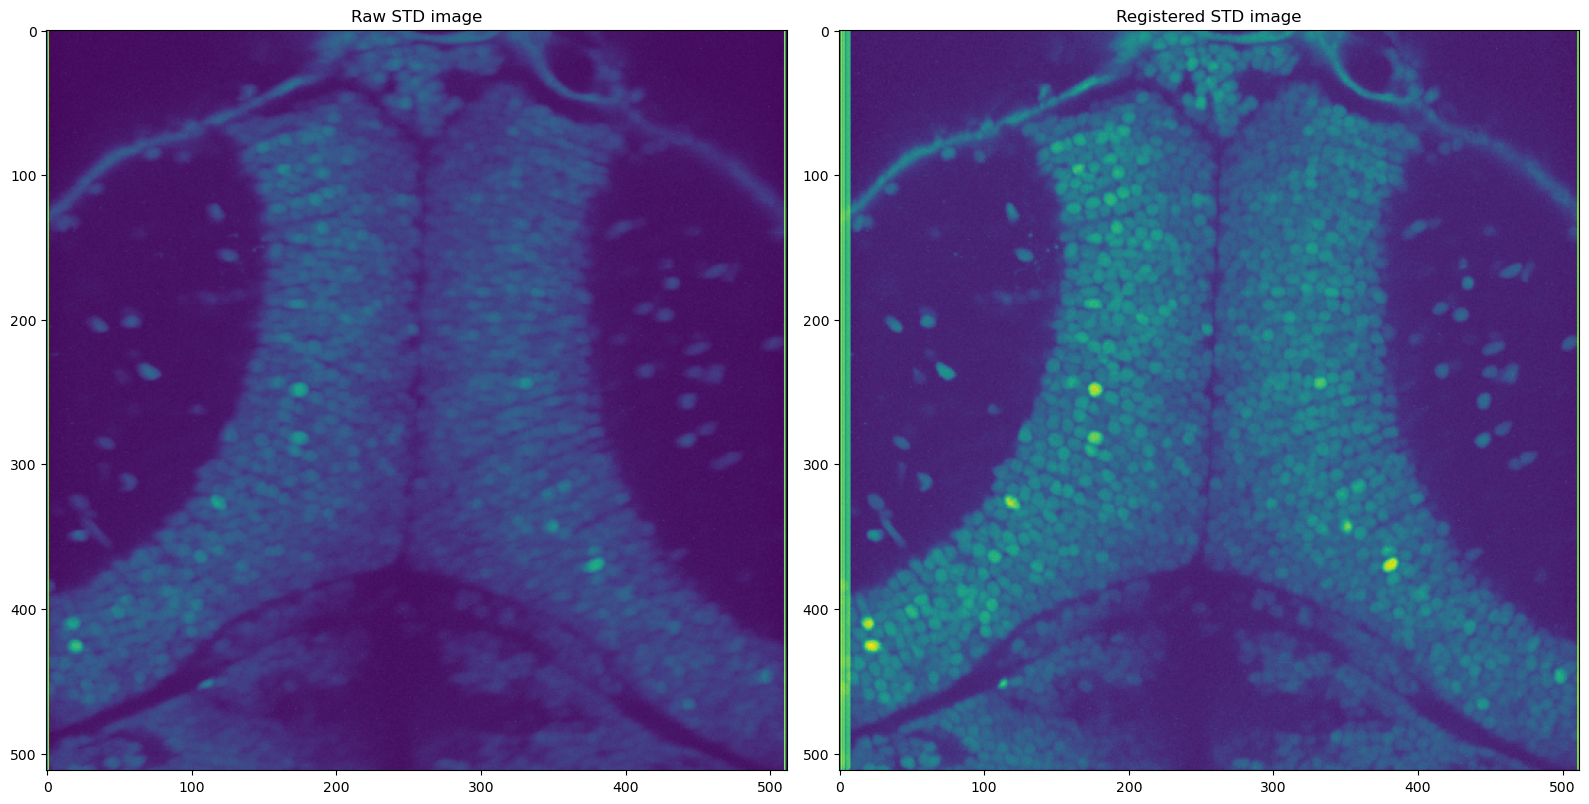

In [4]:
# registration (motion correction) of calcium frames and computation of STD image
reg_frames, std_image = motion_correction(ca_movie, binsize=60, stepsize=40)    #10, 10

## Cell Segmentation

C:\Users\dburkhardt\Desktop\preprocessing_arrenberg_practical_2022-main\final\Exp4.py:162: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  maxCoord = peak_local_max(smoothed_std_image, footprint=conn, indices=False, exclude_border=0)


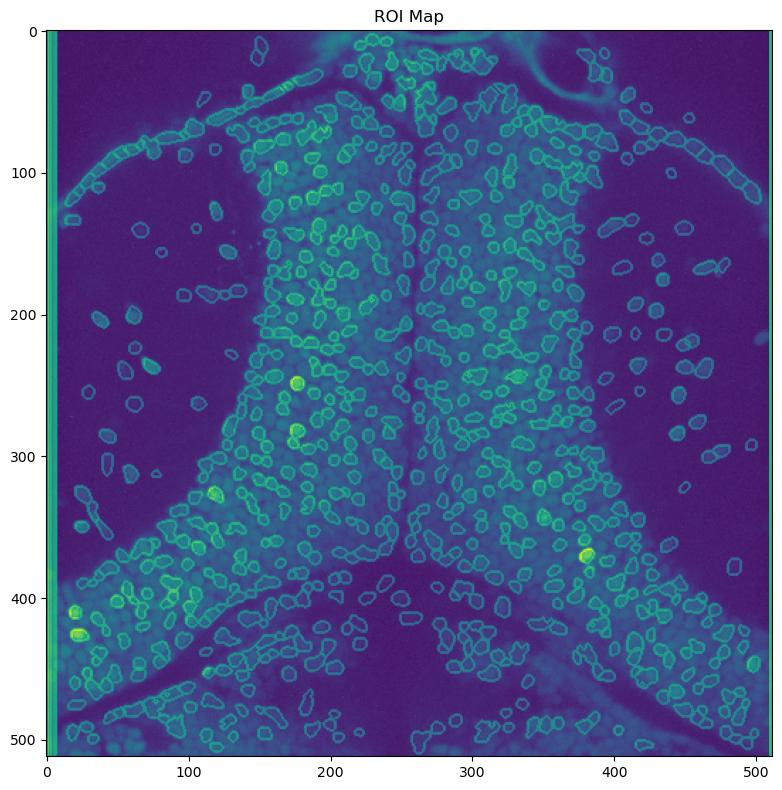

In [5]:
# cell (ROIs) segmentation with watershed algorithm
segmentation_params = {
    'hpfiltSig': .1,
    'localThreKerSize': 9,
    'smoothSig': 3,
    'binaryThre': .5,
    'minSizeLim': 20,
    'maxSizeLim': 500,
    'bgKerSize': 2,
    'fgKerSize': 1
    }
roi_mask = cell_segmentation(std_image, segmentation_params)

In [6]:
# extract calcium traces for ROIs
raw_ca_traces = extract_calcium_signals(roi_mask, reg_frames, display_traces=False)

# size of array
print(np.array(raw_ca_traces).shape)

(750, 3121)


## DF/F Computation
compute DF/f for each calcium trace
* Hint: $\frac{\Delta F}{F} = \frac{F(t) - F_{0}}{F_{0}}$

In [7]:
dff_ca_traces = None # put your calculation here

## Stimulus Parameter Aquisition

Text(0.5, 0, '#frames')

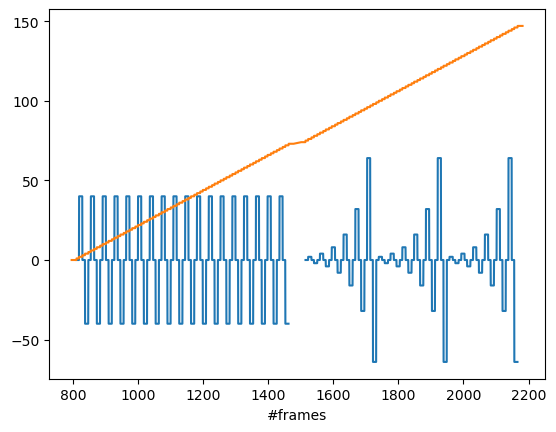

In [8]:
# acquire stimulus parameter for each calcium frames
stim_array = align_stimulus_to_ca_frames(timefn=working_dir+timeline_filename,stim_fn=working_dir+stimulus_filename)

# visualize
plt.figure()
plt.plot(stim_array['time'],stim_array['speed'])
plt.plot(stim_array['time'],stim_array['phase'])
plt.xlabel('#frames')
# plt.plot(stim_array['time'],stim_array['spatial_freq'])

In [9]:
# store ROIs and stimulus parameters  in one DataFrame
roi_id = np.unique(roi_mask)[1:]
formatted = pd.DataFrame(np.array(dff_ca_traces).T,columns=roi_id)
for k,v in stim_array.items():
    formatted["stim_"+k] = v
    
formatted = formatted[formatted['stim_phase'].notna()]
    
# visualize
# formatted.to_csv(working_dir + "test1.csv")
formatted

,1,2,3,4,5,6,7,8,9,10,...,745,746,747,748,749,750,stim_phase,stim_speed,stim_spatial_freq,stim_time
69,115026,108432,109843,36297,32207,11361,134143,91972,59896,153958,...,27979,69550,18245,26601,65818,81541,0.0,NaN,NaN,795.745681
70,141981,100110,89128,43947,18983,19108,152932,108302,38960,130490,...,49045,110731,31564,58360,61016,64988,0.0,NaN,NaN,796.215728
71,117588,117238,74145,41101,26474,15332,124437,69469,51670,128471,...,49430,103137,19303,40145,49813,92907,0.0,NaN,NaN,796.675764
72,165611,75650,72510,52753,20808,13124,109708,85095,40909,136310,...,25321,73328,51638,26762,59256,73410,0.0,NaN,NaN,797.095792
73,156711,96235,86563,27560,35729,35630,84772,71583,34123,154341,...,49716,87899,16643,32973,38636,55540,0.0,NaN,NaN,797.585822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3086,57784,45651,54774,26758,14950,16582,84834,92003,44529,141596,...,24136,68496,22119,16899,67674,39855,147.0,NaN,NaN,2179.819643
3087,83174,69694,73631,39564,17094,27849,90819,71707,31784,102602,...,38704,85530,42640,47378,32299,61753,147.0,NaN,NaN,2180.289678
3088,102668,62364,78402,44430,15877,21254,142528,81282,28741,105582,...,44082,67373,19718,23208,51284,48372,147.0,NaN,NaN,2180.709709
3089,91017,27433,46258,35339,10628,23848,150208,60053,52915,123253,...,52696,112870,35279,31726,54489,41003,147.0,NaN,NaN,2181.199742


Text(0, 0.5, '#ROIs')

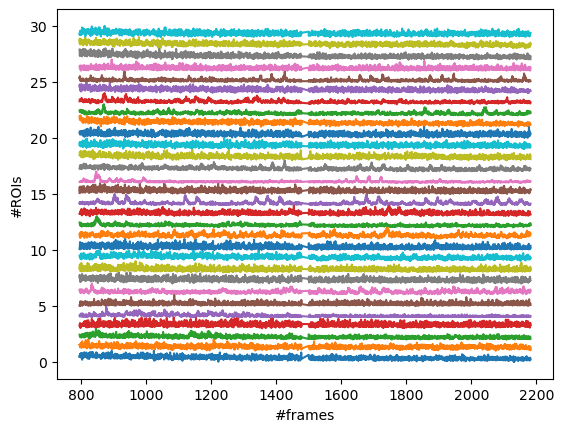

In [10]:
# plot some example calcium traces
plt.figure()
for i in range(30):
    plt.plot(formatted['stim_time'],rnorm(formatted[i+1].to_numpy())+i)
plt.xlabel('#frames')
plt.ylabel('#ROIs')

## ROI Analysis

Text(0.5, 0, 'Frame #')

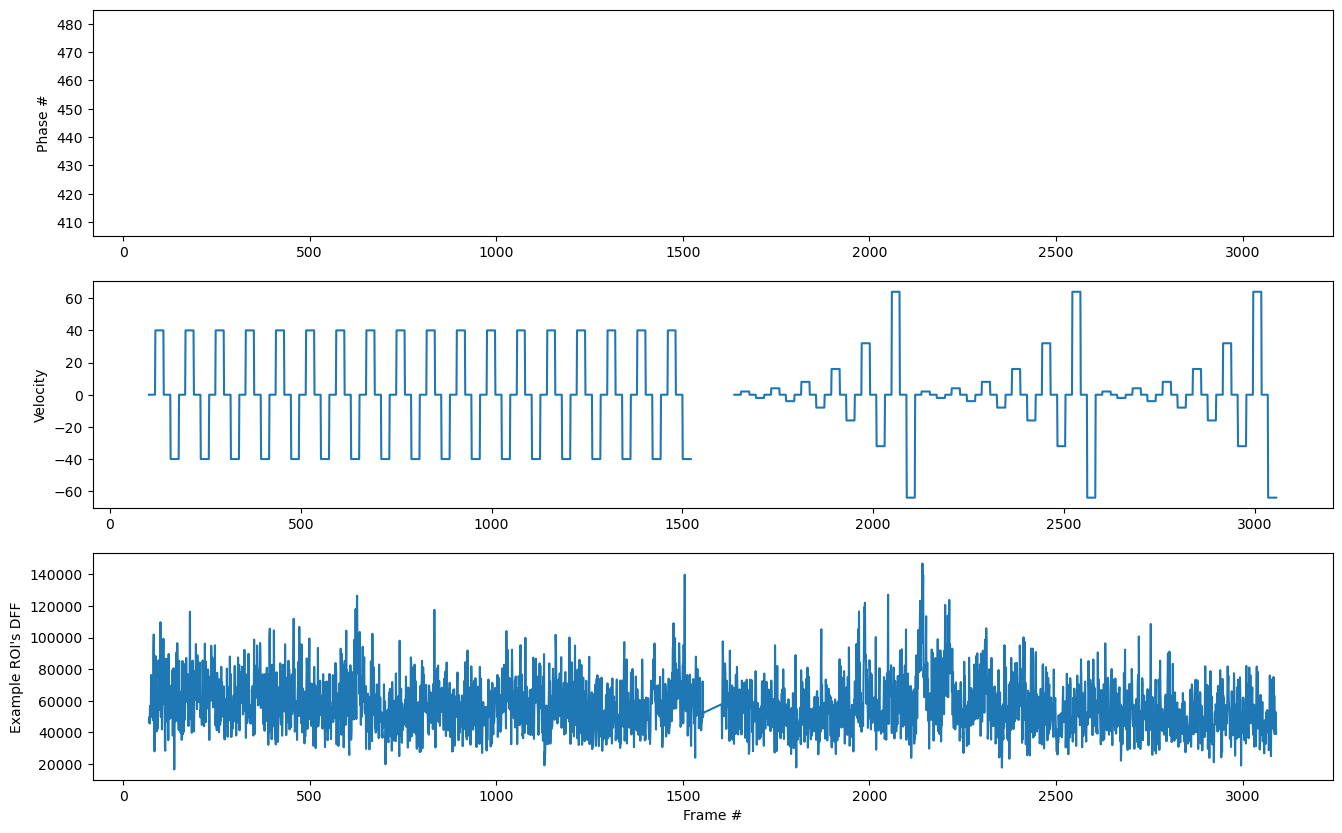

In [11]:
# visualization of stimulus phase, velocity and a example ROI
fig, axes = plt.subplots(3, 1, figsize=(16, 10))
axes[0].plot(formatted['stim_phase'])
axes[0].set_ylim(405, 485)
axes[0].set_ylabel('Phase #')

axes[1].plot(formatted['stim_speed'])
axes[1].set_ylabel('Velocity')

axes[2].plot(formatted[14])
axes[2].set_ylabel('Example ROI\'s DFF')

axes[2].set_xlabel('Frame #')

### Calculate mean DFF for stimulation phase

In [12]:
# put your calculation here

### Calculate auto-correlation between stimulus repeats

In [13]:
# put your calculation here

### Calculate correlation between mean phase-DFF and stimulus regressors

Text(0.5, 0, 'Frame #')

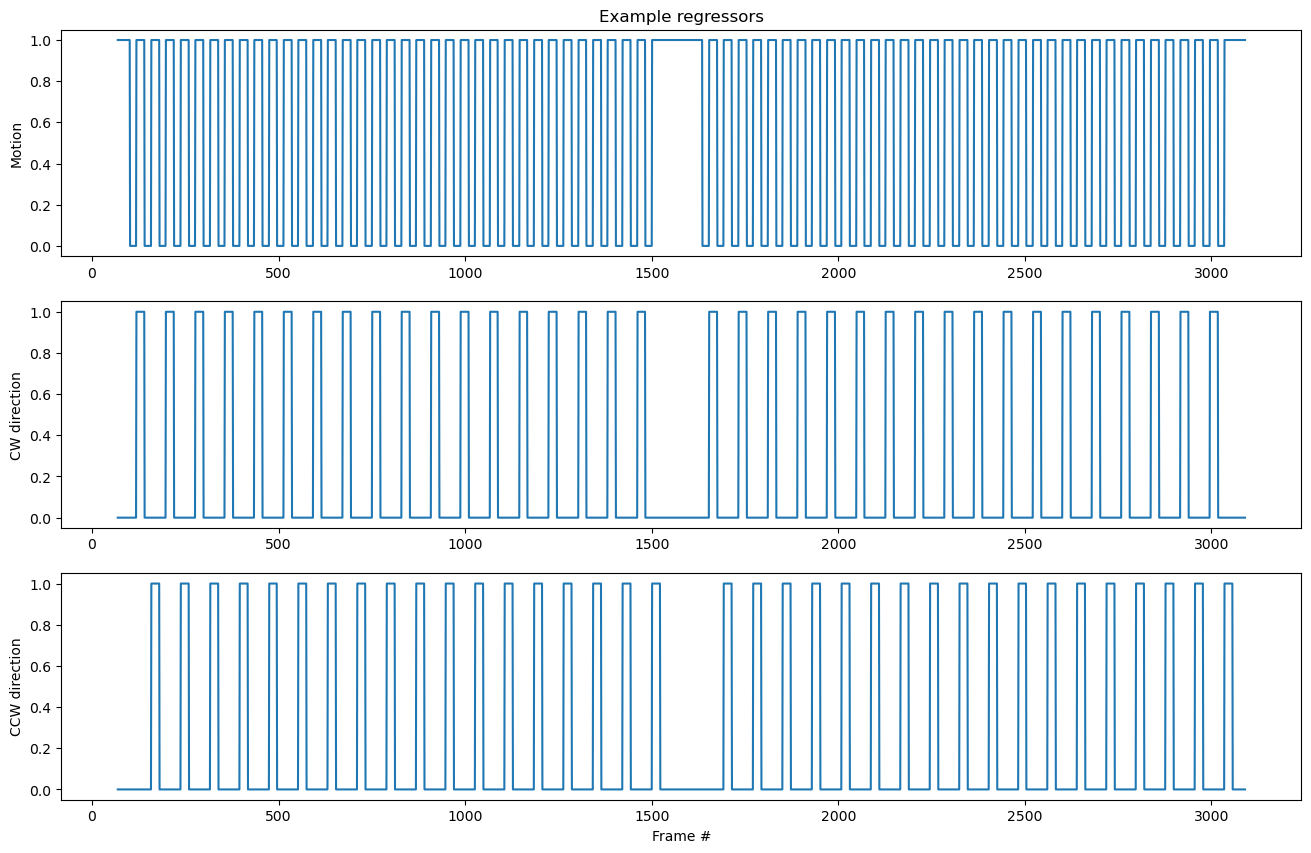

In [14]:
# example plots for different regressors 
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

axes[0].set_title('Example regressors')

axes[0].plot(formatted['stim_speed'] != 0)
axes[0].set_ylabel('Motion')

axes[1].plot(formatted['stim_speed'] > 0)
axes[1].set_ylabel('CW direction')

axes[2].plot(formatted['stim_speed'] < 0)
axes[2].set_ylabel('CCW direction')

axes[2].set_xlabel('Frame #')

In [15]:
# put your calculation here